<a href="https://colab.research.google.com/github/blackkolly/IOT_LAB/blob/main/IOT_LAB2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Euclidean Distance from Gateway 1
[0.84634508 0.84634508 0.84634508 0.84634508 0.84634508 0.84634508
 0.84634508 0.84634508 0.84634508 0.84634508 0.84634508 0.84634508
 0.84634508 0.84634508 0.84634508 0.84634508 0.84634508 0.84634508
 0.84634508 0.84634508 0.84634508 0.84634508 0.84634508 0.84634508
 0.84634508 3.18869879 3.18869879 3.18869879 3.18869879 3.18869879
 3.18869879 3.18869879 3.18869879 3.18869879 3.18869879 3.18869879
 3.18869879 3.18869879 3.18869879 3.18869879 3.18869879 3.18869879
 3.18869879 6.36582281 6.36582281 6.36582281 6.36582281 6.36582281
 6.36582281 6.36582281 6.36582281 6.36582281 6.36582281 6.36582281
 6.36582281 6.36582281 6.36582281 6.36582281 6.36582281 6.36582281
 6.36582281 6.36582281 6.36582281 1.1584904  1.1584904  1.1584904
 1.1584904  1.1584904  1.1584904  1.1584904  1.1584904  1.1584904
 1.1584904  1.1584904  1.1584904  1

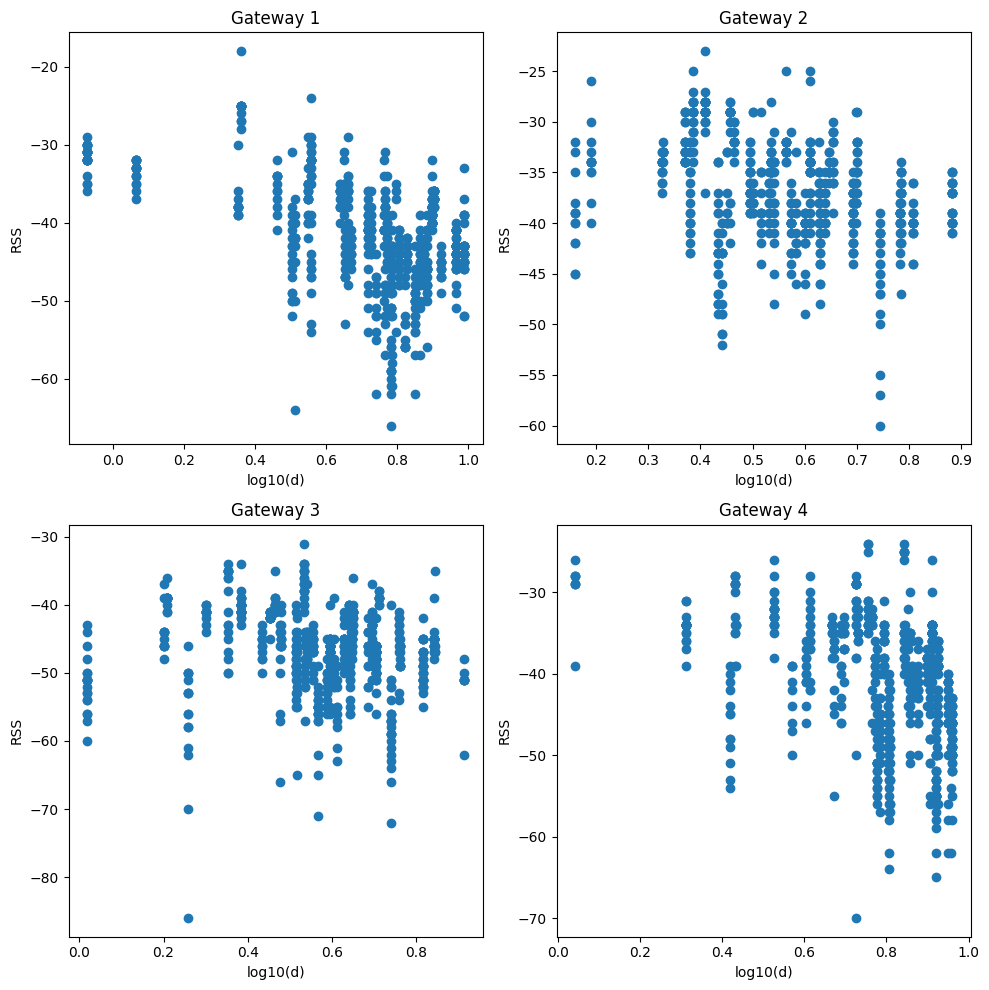

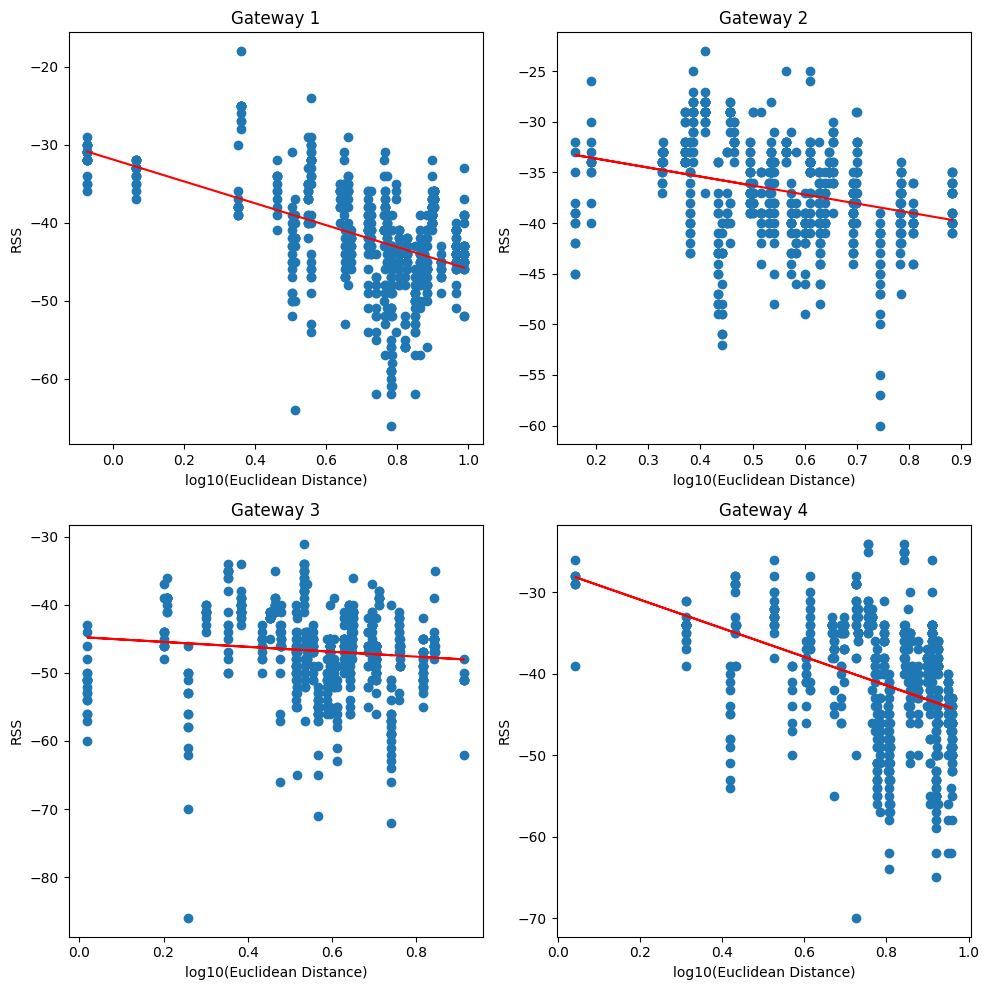

Noise Variances: [34.26008637469693, 21.802337019560692, 37.31922747418465, 50.33198560470758]
[[4.00731605 4.00707976 4.00695265 4.00708819]
 [4.00731605 4.00707976 4.00695265 4.00708819]
 [4.00731605 4.00707976 4.00695265 4.00708819]
 ...
 [6.27475371 6.27415817 6.27529209 6.27470945]
 [6.27475371 6.27415817 6.27529209 6.27470945]
 [6.27475371 6.27415817 6.27529209 6.27470945]]


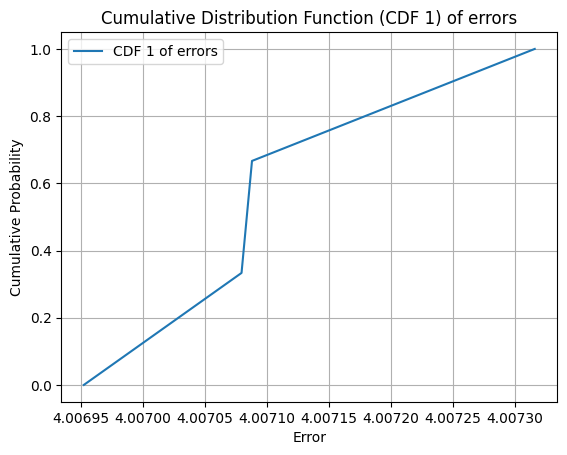

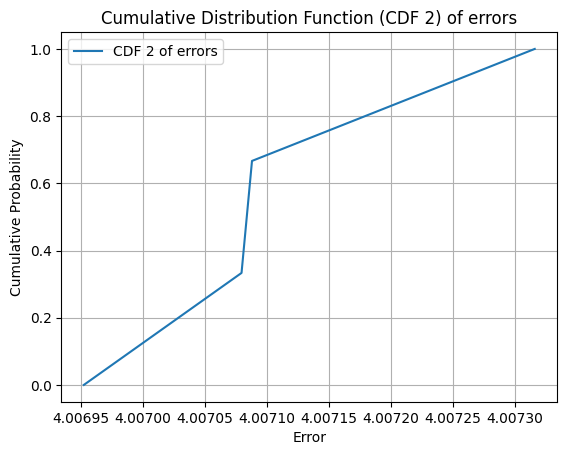

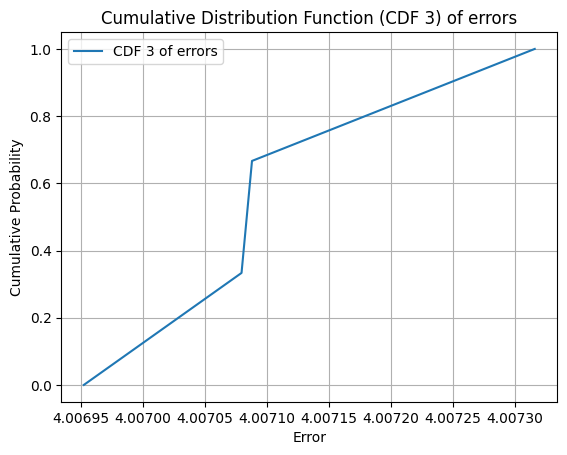

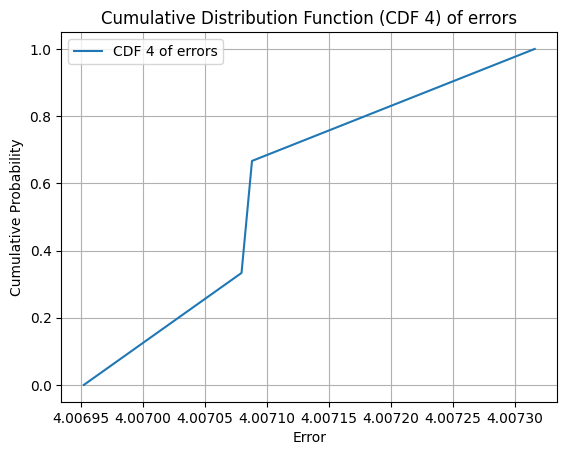

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import scipy.io
from scipy.io import loadmat
from scipy.optimize import least_squares
import math

# Mount Google Drive to access .mat files
drive.mount('/content/drive')

# Function to compute Euclidean distances and their logarithm
def compute_distances(positions, gateways):
    distances = np.linalg.norm(positions[:, np.newaxis] - gateways, axis=2)
    return distances, np.log10(distances)

# Load position and RSS data from .mat files
RSS = scipy.io.loadmat('/mnt/Mat_RSS.mat')['Mat_RSS']
positions = scipy.io.loadmat('/mnt/Mat_Pos.mat')['Mat_Pos']


# Define gateway coordinates
gateways = np.array([
    [1.46, 9.27, 0.85],
    [7, 4.64, 0.85],
    [1.27, 3.9, 1.2],
    [7, 9.9, 0.85]
])

# Compute distances and log distances
distances, log_distances = compute_distances(positions, gateways)

# Print Euclidean distances for each gateway
for i, dist in enumerate(distances.T):
    print(f'Euclidean Distance from Gateway {i+1}')
    print(dist, '\n')

# Plot scatter plots for RSS vs log distances
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    ax.scatter(log_distances[:, i], RSS[:, i])
    ax.set_title(f'Gateway {i+1}')
    ax.set_xlabel('log10(d)')
    ax.set_ylabel('RSS')
plt.tight_layout()
plt.show()

# Function to perform linear regression
def linear_regression(X, Y):
    A = np.column_stack((X, np.ones(X.shape)))
    Z = np.linalg.pinv(A).dot(Y)
    return Z[0] / -10, Z[1], A.dot(Z)

# Compute regression results for each gateway
regression_results = [linear_regression(log_distances[:, i], RSS[:, i]) for i in range(4)]
n_vals, B_vals, Y_preds = zip(*regression_results)

# Plot regression results
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    ax.scatter(log_distances[:, i], RSS[:, i])
    ax.plot(log_distances[:, i], Y_preds[i], color='red')
    ax.set_title(f'Gateway {i+1}')
    ax.set_xlabel('log10(Euclidean Distance)')
    ax.set_ylabel('RSS')
plt.tight_layout()
plt.show()

# Compute noise matrices (difference between actual and predicted RSS values)
noise_matrices = [np.abs(RSS[:, i] - Y_preds[i]) for i in range(4)]
variances = [np.mean(noise**2) for noise in noise_matrices]
print("Noise Variances:", variances)

# Function to estimate position using least squares optimization
def estimate_position(row_index, Y_data):
    initial_guess = np.mean(positions, axis=0)
    result = least_squares(lambda params: np.linalg.norm(params - gateways, axis=1) - Y_data[row_index],
                           initial_guess)
    return result.x

# Estimate positions for each gateway
estimated_positions = np.array([[estimate_position(i, Y_preds[j]) for i in range(Y_preds[j].shape[0])] for j in range(4)])

# Compute positioning errors

def compute_errors(estimated_positions):
     return np.linalg.norm(positions[:, np.newaxis, :] - estimated_positions.transpose(1, 0, 2), axis=2)

erros = compute_errors(estimated_positions)
print(erros)

# Function to compute sorted errors and cumulative distribution function (CDF)
def compute_cdf(errors):
    sorted_errors = np.sort(errors, axis=1)
    cdf = np.linspace(0, 1, sorted_errors.shape[1])
    return sorted_errors, cdf

sorted_errors, cdf = compute_cdf(erros)

# Plot CDF of errors for each gateway
for i in range(4):
    plt.plot(sorted_errors[i], cdf, label=f'CDF {i+1} of errors')
    plt.xlabel('Error')
    plt.ylabel('Cumulative Probability')
    plt.title(f'Cumulative Distribution Function (CDF {i+1}) of errors')
    plt.legend()
    plt.grid(True)
    plt.show()
